In a recent storm our neighbor's cable connection partially unspooled and became a potential hazard as it then hung too low over the road. Our neighbor was able to promptly pull the cable back up by pulling cable off and re-spooling it on their end of the connection.

This got me to thinking: for a cable strung between two points of equal height what shape should one pull the cable to, so as to minimize tension on the endpoints? Should the cable droop a lot or seem to be nearly flat?

The idea is: assume we have two endpoints at the same height over an infinite chasm. The force/tension down on each endpoint is going to be one half the total weight of the cable. So we can increase downward force down by adding in more cable (making the whole system droopier) and decrease the downward force by pulling the cable until nearly horizontal (decreasing the total weight of the system). However the horizontal component of tension is going to be proportional to the "run / rise" of the cable angle at the endpoint (or `-1/slope`). This is because that is the force required to hold the flexible cable at the observed angle. If we did try to pull the cable horizontal, we would induce arbitrarily large horizontal forces. To limit tension we have to let the cable sag or droop trading off vertical and horizontal tensions

The question is: what is the optimal shape? Does the optimal (lowest total tension at attachment points) configuration look droopy or not? This is a basic physics or engineering question.

As a fun exercise, I would like to show how to try to solve such a problem using `sympy` in Python. Forgive me if I make a physics or engineering blunder, but this seems like something once can calculate with just a touch of calculus.

Our goal is to work out at what tension does a hanging non-elastic cable of uniform density exhibit the least tension on its endpoints.

First we take the standard fact that a free hanging non-elastic cable of uniform weight hangs in a shape called a [catenary](https://en.wikipedia.org/wiki/Catenary) arc. That is the height `y` is of the form `y(x) = a * cosh(x / a) - c` for some `a`, `c`.

Let's define our problem as hanging a cable between the horizontal points `(x, y) = (-1, 0)` and `(x, y) = (1, 0)`. In this formulation we have `y(-1) = y(1) = 0`, so `y(x) = a * cosh(x / a) - a * cosh(1 / a)`.

What we want to know is:

  * For a given `a`, the total length of cable hanging. The weight is proportional to this quantity.
  * For a given `a`, the angle cable is hanging at the attachment points. The direction gives the ratio of vertical tension `v` (equal to half the total weight of the cable at each endpoint) and the horizontal tension `h`. Knowing these two tensions gives us the total tension as `t = sqrt(h**2 + v**2)`.

It is then a matter of finding an `a` that minimizes `t`.

Let's work through this using sympy.

In [1]:
# import our packages
from sympy import *
from sympy.solvers import solve, nsolve
import numpy
import pandas
import matplotlib.pyplot
import seaborn

In [2]:
init_printing(use_unicode=True)

In [3]:
# define our free symbols
a, x = symbols('a x')

In [4]:
%%capture
# print once to capture ugly printing system start up messages
a

Now we define `y` as a function of `x`

In [5]:
y = a * cosh(x / a) - a * cosh(1 / a)

y

We confirm `y` hits our endpoints.

In [6]:
y.subs(x, -1)

In [7]:
y.subs(x, 1)

And also that the cable dips under the starting `0`-level.

In [8]:
y.subs(x, 0)

For positive `a`, the above is going negative exactly when `cosh(1/a) > 1`. As `cosh(x) = (exp(x) + exp(-x)) / 2` this is indeed true for all positive `a`.

To get the arc length we need to integrate `sqrt((dx/dx)**2 + (dy/dx)**2)` from `x = -1, ... 1`.

In [9]:
dydx = diff(y, x)

dydx

In [10]:
arc_term = sqrt(1 + dydx**2)

arc_term

At first glance `sympy` won't solve this definite integral for us.

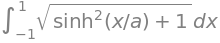

In [11]:
integrate(arc_term, (x, -1, 1))

To solve this we use the standard hyperbolic identity: `cosh**2 - sinh**2 = 1` (for a video on this: https://youtu.be/mnBLG_D1nHg ). This simplifies to a new `arc_term2 = cosh(x / a)`.

In [12]:
arc_term2 = cosh(x / a)

arc_term2

We can confirm the squares of these two terms are in fact identical.

In [13]:
simplify(arc_term**2 - arc_term2**2)

Now we go back to computing the arc length.

In [14]:
arc_length = integrate(arc_term2, (x, -1, 1))

arc_length

We also need the fall rate or slope at the endpoints, that is for a small unit of change in `x`, what is the change in `y`. That is just `dydx` evaluated at `x = -1`.

In [15]:
fall_rate = dydx.subs(x, -1)

fall_rate

Normalizing the vector `(1, fall_rate)` to be unit 2-norm gives us a vector representing 
the angle of the cable at the attachment point.

We normalize the change in `x` and change in `y` to be norm-1, so it represents an angle.

We repeat the trick of replacing `sinh**2 + 1` with `cosh**2` to get:

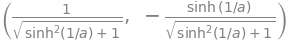

In [16]:
angle_vector = (1 / sqrt(1**2 + fall_rate**2), fall_rate / sqrt(1**2 + fall_rate**2))

angle_vector

Again, the `sinh**2 + 1` can be more neatly written as `cosh**2`.

Now we know the vertical component of the tension must equal to half of the total weight of the system. We are assuming a constant weight per unit wire, so we can ignore scaling and assume the total weight of the system is `arc_length`. So we must have `(1/2) arc_length = - angle_vector[1] * total_tension`. Solving for `total_tension` gives us:

In [19]:
total_tension = - (1/2) * arc_length / angle_vector[1]

total_tension

So, for a given `a` the total system weighs `arc_length` units. Thus we want an `a` minimizing the `total_tension`. Such an extreme is either going to happen at our endpoints (`a` zero or positive infinity) or at a place where the derivative is zero. Let's take a look at where the derivative is zero.

In [20]:
deriv = diff(total_tension, a)

deriv

Now we solve for an `a` that takes this derivative to zero.

In [21]:
soln_a = nsolve((deriv, ), (a, ), (1.0, ))[0]

soln_a

And we then plug that `a` into our angle vector to get the vector representing the angle that minimizes tension at the endpoints.

In [22]:
soln_vector = (angle_vector[0].subs(a, soln_a), angle_vector[1].subs(a, soln_a))

soln_vector

This means the tension is minimized when the fall/run (or -slope) at the endpoint is about `0.833 / 0.552` (approximately `1.5` to `1`). Or visually, the cable should look fairly slack. The angle in degrees of the cable at the left attachment point is given by:

In [23]:
attachment_angle = 360 * atan2(soln_vector[1], soln_vector[0]) / (2 * N(pi))

attachment_angle

So the least tension solution is about `-56` degrees (not `-45` degrees, and definitely not flat- where we would experience infinite horizontal tension).

Let's take a look at the optimal solution.

In [24]:
opt_curve = y.subs(a, soln_a)

opt_curve

In [25]:
plot_frame = pandas.DataFrame({
    'x': numpy.linspace(
        start=-1, 
        stop=1, 
        endpoint=True, 
        num=1000),
})

In [26]:
# lowest point
lowest_point = float(opt_curve.subs(x, 0))

lowest_point

In [27]:
plot_frame['y'] = [
    float(opt_curve.subs(x, xv)) for xv in plot_frame['x']]

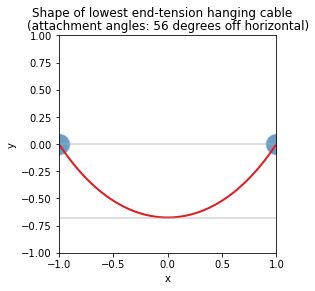

In [28]:
ax = seaborn.lineplot(
    data=plot_frame,
    x='x',
    y='y',
    color='#e41a1c',
    linewidth=2.0,
)
ax.set(ylim=(-1, 1))
ax.set(xlim=(-1, 1))
ax.set_box_aspect(1)
seaborn.scatterplot(
    x=[-1, 1],
    y=[0, 0],
    s=500.0,
    color='#377eb8',
    alpha=0.75,
)
seaborn.lineplot(
    x=[-1, 1],
    y=[0, 0],
    color='darkgrey',
    alpha=0.5,
)
seaborn.lineplot(
    x=[-1, 1],
    y=[lowest_point, lowest_point],
    color='darkgrey',
    alpha=0.5,
)
attachment_angle_string = '{0:.2g}'.format(abs(attachment_angle))
matplotlib.pyplot.suptitle(
    'Shape of lowest end-tension hanging cable')
_ = matplotlib.pyplot.title(
    f'(attachment angles: {attachment_angle_string} degrees off horizontal)')

And that is what a minimum tension hanging cable path should look like. On our street, a truck would drive right into that. Fortunately our neighbor did not get distracted by the the math, and thought to pull the cable much tauter than that.